Performing Exploratory Data Analysis on the CMEG File

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\subha\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\subha\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\subha\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\subha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cmeg_df = pd.read_excel('cmeg_df_case_competition_scrambled_train.xlsx', sheet_name='Data')

In [3]:
cmeg_df = cmeg_df.sort_values(by = ['ROW'], ascending=False)

In [4]:
for i in range(cmeg_df.shape[1]):
    n_miss = cmeg_df.iloc[:, [i]].isnull().sum()
    perc = n_miss / cmeg_df.shape[0] * 100
    print('> %s, Missing: %d (%.1f%%)' % (cmeg_df.columns[i], n_miss, perc))

> ROW, Missing: 0 (0.0%)
> Corp_Residence_Country_Code, Missing: 0 (0.0%)
> BR Code, Missing: 0 (0.0%)
> Period, Missing: 0 (0.0%)
> CUSTOMER_ID, Missing: 0 (0.0%)
> Final_IG, Missing: 0 (0.0%)
> B_PLUS_FLAG, Missing: 0 (0.0%)
> EBITDA_Y0, Missing: 597 (2.1%)
> EBITDA_Y1, Missing: 2361 (8.4%)
> EBITDA_Y2, Missing: 8434 (29.9%)
> EBITDA_Y3, Missing: 14186 (50.3%)
> TOTALASSET_Y0, Missing: 381 (1.3%)
> TOTALASSET_Y1, Missing: 2210 (7.8%)
> TOTALASSET_Y2, Missing: 8292 (29.4%)
> TOTALASSET_Y3, Missing: 14112 (50.0%)
> TOTALDEBT_Y0, Missing: 875 (3.1%)
> TOTALDEBT_Y1, Missing: 2718 (9.6%)
> TOTALDEBT_Y2, Missing: 8714 (30.9%)
> TOTALDEBT_Y3, Missing: 14358 (50.9%)
> TOTALREVENUE_Y0, Missing: 819 (2.9%)
> TOTALREVENUE_Y1, Missing: 2577 (9.1%)
> TOTALREVENUE_Y2, Missing: 8591 (30.4%)
> TOTALREVENUE_Y3, Missing: 14290 (50.6%)
> CURRENTASSET_Y0, Missing: 789 (2.8%)
> CURRENTASSET_Y1, Missing: 2585 (9.2%)
> CURRENTASSET_Y2, Missing: 8571 (30.4%)
> CURRENTASSET_Y3, Missing: 14269 (50.6%)
> FIXED

In [5]:
#non-financial features
non_fin_features = ['ROW', 'Corp_Residence_Country_Code', 'BR Code', 'Period', 'CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG']
#financial features
fin_features = np.sort(list(set(cmeg_df.columns) - set(non_fin_features)))

In [6]:
#calculating 3 year averages
def three_year_average(X, col_y0, col_y1, col_y2, col):
    X.drop(X[X[col_y0].isnull()].index, inplace = True)
    
    X[col] = X[col_y0]
    
    two_years_average = X[col_y1].notnull() & X[col_y2].isnull()
    X.loc[two_years_average, col] = X.loc[two_years_average, col_y0] * 4/7 + X.loc[two_years_average, col_y1] * 3/7
    
    three_years_average = X[col_y1].notnull() & X[col_y2].notnull()
    X.loc[three_years_average, col] = X.loc[three_years_average, col_y0] * 4/9 + X.loc[three_years_average, col_y1] * 3/9 + X.loc[three_years_average, col_y2] * 2/9
    
    return X

cols_to_avg = []

for col in fin_features:
    if (col.endswith('Y0') and not col.endswith('growth_Y0')):
        cols_to_avg.append([col, col[:-2] + 'Y1', col[:-2] + 'Y2', col[:-2] + '3YearAverage'])

data_left = cmeg_df.copy()
for col0, col1, col2, col in cols_to_avg:
    orig_num_data = len(data_left)
    data_left = three_year_average(data_left, col0, col1, col2, col)
    remaining_data = len(data_left)
    print((orig_num_data - remaining_data), 'data records are dropped due to ' + col + '\n')

1024 data records are dropped due to ARTurnover_3YearAverage

75 data records are dropped due to ASSETTURNOVER_3YearAverage

61 data records are dropped due to CAPITALIZATION_3YearAverage

280 data records are dropped due to CCE_3YearAverage

0 data records are dropped due to CURRENTASSET_3YearAverage

0 data records are dropped due to CURRENTLIABILITY_3YearAverage

2266 data records are dropped due to Capex2Dep_3YearAverage

0 data records are dropped due to DEBTSERVCOV_3YearAverage

0 data records are dropped due to EBITDAR_3YearAverage

0 data records are dropped due to EBITDA_3YearAverage

4462 data records are dropped due to FCF_3YearAverage

0 data records are dropped due to FIXEDASSET_3YearAverage

0 data records are dropped due to FIXEDCHARGECOV_3YearAverage

2501 data records are dropped due to INVENTORYDAYS_3YearAverage

0 data records are dropped due to Inventory_3YearAverage

0 data records are dropped due to LEASERENTEXP_3YearAverage

0 data records are dropped due to NETP

In [7]:
data_left = data_left.reset_index(drop = True)

In [8]:
#calculating financial ratios
for i in range(4):
    data_left['DEBT2EBITDA_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['EBITDA_Y' + str(i)]
    data_left['DEBT2CAPT_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['CAPITALIZATION_Y' + str(i)]
    data_left['DEBT2EQUITY_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALEQUITY_Y' + str(i)]
    data_left['DEBT2ASSET_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['DEBT2TANGIBLENW_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['tangibleNetWorth_Y' + str(i)]
    data_left['CASH2ASSET_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['CASH2DEBT_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALDEBT_Y' + str(i)]
    data_left['CA2CL_Y'+str(i)] = data_left['CURRENTASSET_Y'+str(i)] / data_left['CURRENTLIABILITY_Y' + str(i)]
    
for i in range(3):
    data_left['DEBT2FCF_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] / data_left['FCF_Y'+str(i)]

In [9]:
#adding new features
new_feat = ['DEBT2EBITDA_Y','DEBT2CAPT_Y', 'DEBT2EQUITY_Y', 'DEBT2ASSET_Y', 'DEBT2TANGIBLENW_Y', 'CASH2ASSET_Y', 'CASH2DEBT_Y', 'CA2CL_Y']
for i in range(4):
    for feat in new_feat:
        fin_features = list(fin_features) + list([feat + str(i)])

for i in range(3):
    fin_features = list(fin_features) + list(['DEBT2FCF_Y'+str(i)])

fin_features = np.sort(fin_features)

B_FLAG_DIVISIONS

In [10]:
data_left.groupby(['B_PLUS_FLAG']).size()

B_PLUS_FLAG
0     2752
1    14246
dtype: int64

Getting top 20 industry codes with most records

In [11]:
top_br_code = data_left.groupby(['BR Code']).count().sort_values(by = 'ROW', ascending = False).head(20).reset_index()
top_br = top_br_code['BR Code'].tolist()
data = data_left[data_left['BR Code'].isin(top_br)]
data['BR Code'].value_counts()

5     5016
12    1782
4     1019
21     851
30     756
13     567
0      565
8      545
11     521
19     448
42     364
2      342
18     329
3      320
33     319
16     286
34     282
26     270
35     260
24     152
Name: BR Code, dtype: int64

Relationship between B_PLUS_Flag and Industry Code

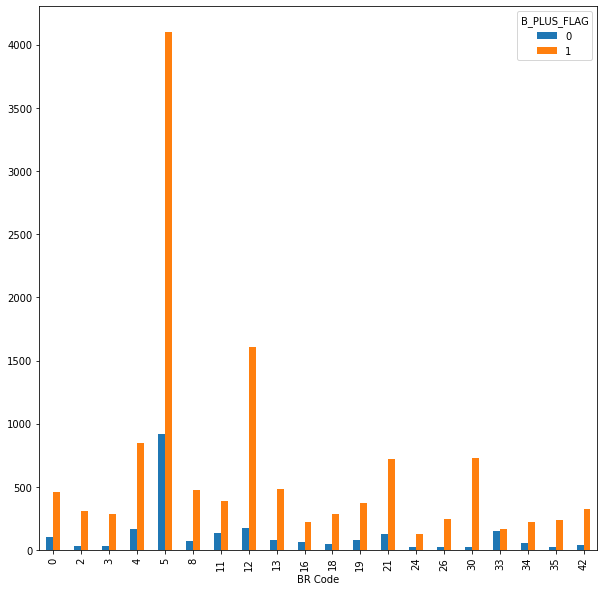

In [12]:
data.groupby(['BR Code', 'B_PLUS_FLAG']).B_PLUS_FLAG.count().unstack().plot(kind='bar', legend=True, figsize = (10,10) )

In [13]:
data.groupby(['BR Code', 'B_PLUS_FLAG']).size()

BR Code  B_PLUS_FLAG
0        0               107
         1               458
2        0                34
         1               308
3        0                33
         1               287
4        0               168
         1               851
5        0               918
         1              4098
8        0                68
         1               477
11       0               136
         1               385
12       0               178
         1              1604
13       0                80
         1               487
16       0                63
         1               223
18       0                44
         1               285
19       0                76
         1               372
21       0               130
         1               721
24       0                23
         1               129
26       0                21
         1               249
30       0                28
         1               728
33       0               149
         1            

Industry codes like 2,3,8,12,26,30,42 have strong affinity to 1

Analyzing top 5 industry codes which have the most records

In [14]:
top_5_br = data_left[data_left['BR Code'].isin([5,12,4,21,30])]
top_5_br['Debt2cap_quantile'] = pd.qcut(top_5_br['DEBT2CAPT_Y0'], 4, labels = False)
top_5_br['Debt2equity_quantile'] = pd.qcut(top_5_br['DEBT2EQUITY_Y0'], 4, labels = False)
top_5_br['Cash2asset_quantile'] = pd.qcut(top_5_br['CASH2ASSET_Y0'], 4, labels = False)
top_5_br['Debt2asset_quantile'] = pd.qcut(top_5_br['DEBT2ASSET_Y0'], 4, labels = False)

C:\Users\subha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\subha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\subha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Looking at relation between industry codes and cash2asset

In [15]:
top_5_br.groupby(['BR Code', 'Cash2asset_quantile']).size()

BR Code  Cash2asset_quantile
4        0                       243
         1                       251
         2                       278
         3                       247
5        0                      1273
         1                      1236
         2                      1235
         3                      1272
12       0                       432
         1                       459
         2                       422
         3                       469
21       0                       228
         1                       201
         2                       226
         3                       196
30       0                       180
         1                       209
         2                       195
         3                       172
dtype: int64

No clear majority in any of the quantiles for any of the industry codes

Looking at relation between industry codes and Debt2Equity

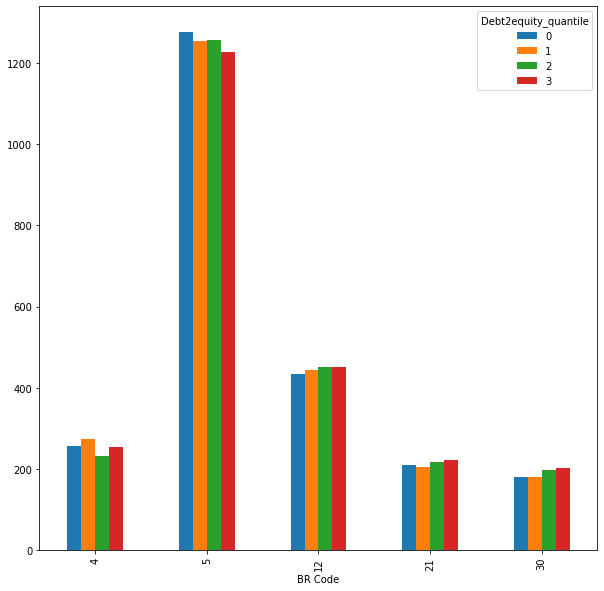

In [16]:
top_5_br.groupby(['BR Code', 'Debt2equity_quantile']).Debt2equity_quantile.count().unstack().plot(kind='bar', legend=True, figsize = (10,10) )

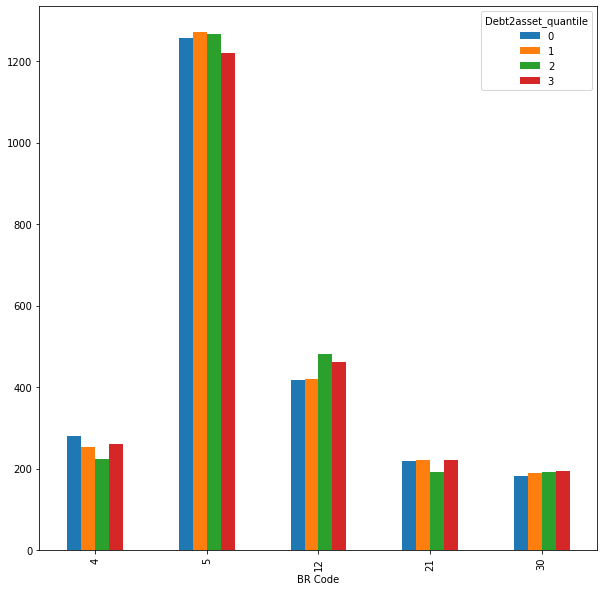

In [17]:
top_5_br.groupby(['BR Code', 'Debt2asset_quantile']).Debt2asset_quantile.count().unstack().plot(kind='bar', legend=True, figsize = (10,10) )

In [18]:
top_5_br.groupby(['BR Code', 'Debt2equity_quantile']).size()

BR Code  Debt2equity_quantile
4        0                        257
         1                        274
         2                        233
         3                        255
5        0                       1276
         1                       1255
         2                       1258
         3                       1227
12       0                        434
         1                        444
         2                        452
         3                        452
21       0                        210
         1                        204
         2                        216
         3                        221
30       0                        179
         1                        179
         2                        197
         3                        201
dtype: int64

In [19]:
top_5_br.groupby(['BR Code', 'Debt2asset_quantile']).size()

BR Code  Debt2asset_quantile
4        0                       281
         1                       254
         2                       224
         3                       260
5        0                      1258
         1                      1271
         2                      1267
         3                      1220
12       0                       417
         1                       421
         2                       482
         3                       462
21       0                       219
         1                       221
         2                       191
         3                       220
30       0                       181
         1                       189
         2                       192
         3                       194
dtype: int64

In [21]:
top_5_br['TOTALREVENUE_3YearAverage_quantile'] = pd.qcut(top_5_br['TOTALREVENUE_3YearAverage'], 4, labels = False)
top_5_br.groupby(['BR Code', 'TOTALREVENUE_3YearAverage_quantile']).size()

C:\Users\subha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


BR Code  TOTALREVENUE_3YearAverage_quantile
4        0                                      184
         1                                      210
         2                                      258
         3                                      367
5        0                                     1290
         1                                     1271
         2                                     1216
         3                                     1239
12       0                                      367
         1                                      435
         2                                      488
         3                                      492
21       0                                      252
         1                                      214
         2                                      209
         3                                      176
30       0                                      263
         1                                      226
         2          

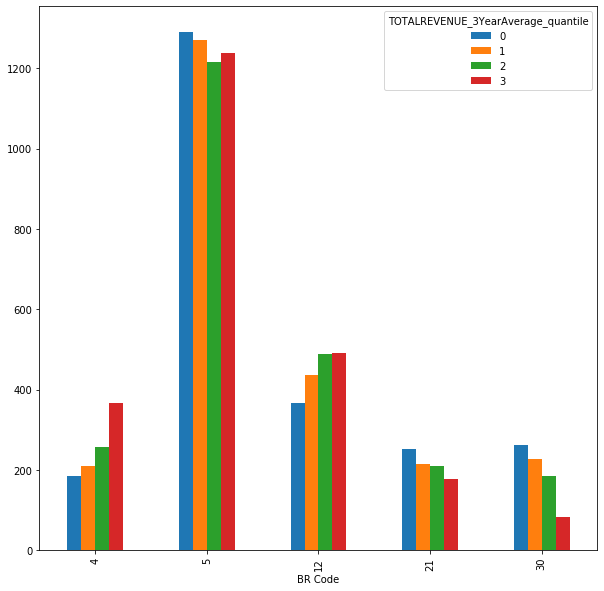

In [22]:
top_5_br.groupby(['BR Code', 'TOTALREVENUE_3YearAverage_quantile']).TOTALREVENUE_3YearAverage_quantile.count().unstack().plot(kind='bar', legend=True, figsize = (10,10) )

Industry code 4 have majority of their records in the higher quintals whereas industry code 30 has most of its records in the lower quintals

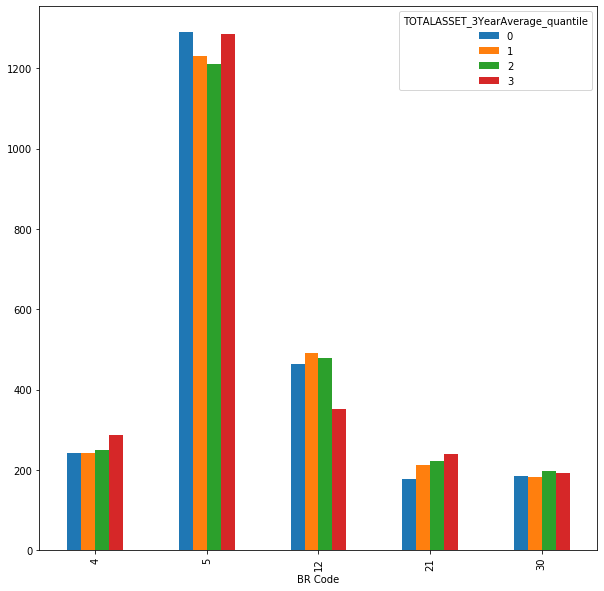

In [25]:
top_5_br.groupby(['BR Code', 'TOTALASSET_3YearAverage_quantile']).TOTALASSET_3YearAverage_quantile.count().unstack().plot(kind='bar', legend=True, figsize = (10,10) )

In [26]:
top_5_br['TOTALASSET_3YearAverage_quantile'] = pd.qcut(top_5_br['TOTALASSET_3YearAverage'], 4, labels = False)
top_5_br.groupby(['BR Code', 'TOTALASSET_3YearAverage_quantile']).size()

C:\Users\subha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


BR Code  TOTALASSET_3YearAverage_quantile
4        0                                    241
         1                                    241
         2                                    250
         3                                    287
5        0                                   1290
         1                                   1231
         2                                   1210
         3                                   1285
12       0                                    463
         1                                    490
         2                                    478
         3                                    351
21       0                                    177
         1                                    213
         2                                    221
         3                                    240
30       0                                    185
         1                                    181
         2                                    197
        

In [27]:
data_left['Revenue_increase']=np.where(data_left['TOTALREVENUE_Y0'] > data_left['TOTALREVENUE_Y1'], 'Y','N')
data_left.groupby(['B_PLUS_FLAG', 'Revenue_increase']).size()

B_PLUS_FLAG  Revenue_increase
0            N                   1461
             Y                   1291
1            N                   7261
             Y                   6985
dtype: int64

Relation between revenue increase and Final_IG

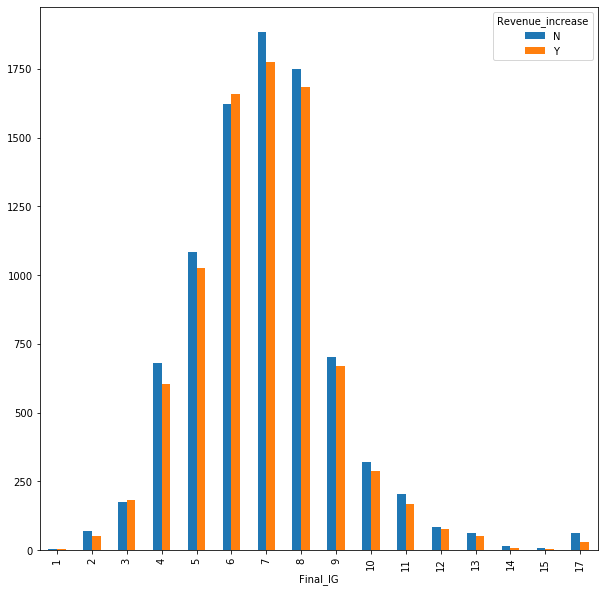

In [28]:
data_left.groupby(['Final_IG', 'Revenue_increase']).Revenue_increase.count().unstack().plot(kind='bar', legend=True, figsize = (10,10) )

In [29]:
data_left.groupby(['Final_IG', 'Revenue_increase']).size()

Final_IG  Revenue_increase
1         N                      3
          Y                      3
2         N                     68
          Y                     53
3         N                    174
          Y                    182
4         N                    680
          Y                    605
5         N                   1083
          Y                   1027
6         N                   1622
          Y                   1657
7         N                   1882
          Y                   1775
8         N                   1749
          Y                   1683
9         N                    702
          Y                    668
10        N                    321
          Y                    286
11        N                    204
          Y                    167
12        N                     85
          Y                     76
13        N                     62
          Y                     50
14        N                     14
          Y                 

Revenue increase does not have much of an impact in higher FINAL_IG

Relation between Asset increase and Final_IG

In [31]:
data_left['Asset_increase']=np.where(data_left['TOTALASSET_Y0'] > data_left['TOTALASSET_Y1'], 'Y','N')
data_left.groupby(['Final_IG', 'Asset_increase']).size()

Final_IG  Asset_increase
1         N                    2
          Y                    4
2         N                   57
          Y                   64
3         N                  183
          Y                  173
4         N                  649
          Y                  636
5         N                 1064
          Y                 1046
6         N                 1680
          Y                 1599
7         N                 1832
          Y                 1825
8         N                 1797
          Y                 1635
9         N                  711
          Y                  659
10        N                  338
          Y                  269
11        N                  187
          Y                  184
12        N                   92
          Y                   69
13        N                   56
          Y                   56
14        N                   12
          Y                   11
15        N                   10
          Y       

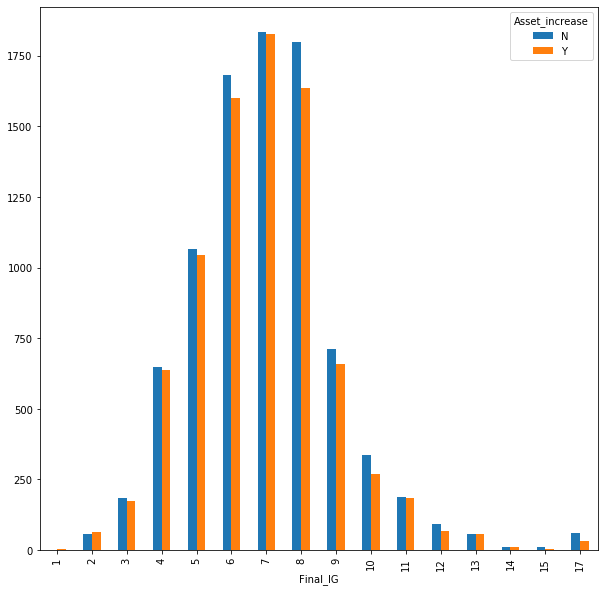

In [32]:
data_left.groupby(['Final_IG', 'Asset_increase']).Asset_increase.count().unstack().plot(kind='bar', legend=True, figsize = (10,10) )

Asset increase does not have much of an impact on Final_IG